# Quick, Draw! Doodle Recognition Challenge

### 1. Preprocessing
* **data size issue**: 기본 데이터의 크기가 73GB로 현재 커널에서 학습 불가 --> 한 번에 학습 시킬 수 있는 크기로 축소 (Shuffle CSVs Kernel 데이터 사용)
* **drawing feature**: stroke-base로 구성된 데이터이기 때문에 cv2모듈을 사용하여 이미지 데이터로 변환 작업 수행 (timespamp마다 점을 pixel 단위로 표시하는 작업을 통해 변환)

### 2. Prediction
* **MobileNet 사용**: 기존의 Convolution은 입력을 필터링하고 통합하는 과정이 한번에 이루어지지만, MobileNet은 필터링 층과 통합층을 분리하여 망을 구성함으로써 기존의 CNN보다 계산량을 줄일 수 있다.
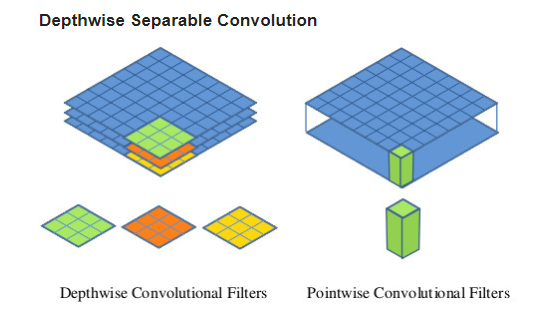

In [ ]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt

# third party library
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# visualazation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns

start = dt.datetime.now()

In [ ]:
DP_DIR = '../input/shuffle-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [ ]:
def apk(actual, predicted, k=3):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [ ]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 680

In [ ]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

print(model.summary())

In [ ]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [ ]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

In [ ]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=70, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [ ]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

In [ ]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

In [ ]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

In [ ]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission.csv', index=False)
submission.head()
submission.shape

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))